# Análise Exploratória de Dados

Análise do mercado de aluguéis temporários na cidade de Nova York (EUA).

Dados disponibilizados pela Indicium para a realização do desafio Lighthouse.

Autor: Raphael Fleury

## Objetivo
O objetivo desta análise é identificar quais fatores mais interferem no preço dos apartamentos e a partir disso responder as seguintes perguntas:
- Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
- O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
- Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Além disso, estes dados também serão usados para desenvolver um modelo de previsão de preços.

## Estratégia
Para obter um resultado preciso sobre como o preço se altera conforme as características do apartamento, serão adotados os seguintes passos:
- Limpeza dos dados, removendo outliers que podem distorcer as estatísticas
- Inserção de informações sobre os bairros a partir de outra base de dados para saber como cada característica interfere no preço
- Transformação de variáveis qualitativas em quantitativas para calcular sua correlação com o preço

## 1. Análise e limpeza dos dados

### 1.1. Análise inicial, ajustes de tipo e tratamento de nulos

Leitura do CSV:

In [77]:
import pandas as pd
apartamentos = pd.read_csv('./datasets/precificacao.csv')

Visualização dos dados:

In [78]:
apartamentos.head(2)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


Analisando o tipo de cada coluna e o número de valores não-nulos:

In [79]:
apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

Convertendo a coluna "ultima_review" para o formato adequado, de texto para data:

In [80]:
apartamentos["ultima_review"] = pd.to_datetime(apartamentos["ultima_review"])
apartamentos["ultima_review"].describe()

count                            38842
mean     2018-10-04 01:46:50.710055936
min                2011-03-28 00:00:00
25%                2018-07-08 00:00:00
50%                2019-05-19 00:00:00
75%                2019-06-23 00:00:00
max                2019-07-08 00:00:00
Name: ultima_review, dtype: object

Verificando quantos valores nulos há em cada coluna:

In [81]:
# Valores nulos em cada coluna
nulos = apartamentos.isnull().sum()
nulos[nulos > 0]

nome                  16
host_name             21
ultima_review      10052
reviews_por_mes    10052
dtype: int64

Substituindo valores nulos:
- nome: substituídos por um texto vazio
- host_name: substituídos pelo id do host
- reviews_por_mes: substituídos por 0

In [82]:
apartamentos['nome'] = apartamentos['nome'].fillna('')
apartamentos['host_name'] = apartamentos['host_name'].fillna(apartamentos["host_id"].astype(str))
apartamentos['reviews_por_mes'] = apartamentos['reviews_por_mes'].fillna(0)
apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   nome                           48894 non-null  object        
 2   host_id                        48894 non-null  int64         
 3   host_name                      48894 non-null  object        
 4   bairro_group                   48894 non-null  object        
 5   bairro                         48894 non-null  object        
 6   latitude                       48894 non-null  float64       
 7   longitude                      48894 non-null  float64       
 8   room_type                      48894 non-null  object        
 9   price                          48894 non-null  int64         
 10  minimo_noites                  48894 non-null  int64         
 11  numero_de_revie

### 1.2. Busca de outliers

Analisando estatísticas sobre cada coluna a fim de encontrar dados destoantes e potencialmente prejudiciais às análises:

In [83]:
apartamentos.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842,48894.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,2018-10-04 01:46:50.710055936,1.090928,7.144005,112.776169
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,2011-03-28 00:00:00,0.000000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,2018-07-08 00:00:00,0.040000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,2019-05-19 00:00:00,0.370000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2019-06-23 00:00:00,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,NaN,1.597294,32.952855,131.618692


A partir desta tabela é possível observar que:
- Há apartamentos com preço igual a 0
- Há apartamentos com preços que se destoam muito
- Há poucos apartamentos com um número mínimo de noites altíssimo
- Há apartamentos que não estão disponíveis em nenhum dia
- Há poucos hospedeiros com um número de listagens muito mais alto que o geral

#### 1.2.1. Buscando outliers no preço

Analisando os apartamentos com o preço igual a zero para tentar encontrar alguma justificativa:

In [84]:
# Apartamentos com preço igual a 0
apartamentos[apartamentos['price'] == 0].describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,1.100000e+01,1.100000e+01,11.000000,11.000000,11.0,11.000000,11.000000,10,11.000000,11.000000,11.000000
mean,2.057179e+07,5.862573e+07,40.712058,-73.925670,0.0,7.363636,34.272727,2018-12-30 00:00:00,1.579091,4.272727,120.909091
min,1.875060e+07,1.641537e+06,40.681730,-73.975970,0.0,1.000000,0.000000,2017-10-27 00:00:00,0.000000,1.000000,0.000000
25%,2.056598e+07,1.192073e+07,40.686510,-73.943585,0.0,1.500000,2.500000,2018-05-10 06:00:00,0.130000,3.000000,14.000000
50%,2.063963e+07,8.632710e+07,40.692110,-73.913420,0.0,2.000000,12.000000,2019-06-04 00:00:00,0.530000,5.000000,127.000000
75%,2.078688e+07,9.414883e+07,40.716500,-73.910490,0.0,4.500000,74.000000,2019-06-21 18:00:00,3.420000,6.000000,199.000000
max,2.130432e+07,1.316976e+08,40.832960,-73.886680,0.0,30.000000,95.000000,2019-06-24 00:00:00,4.370000,6.000000,333.000000
std,6.767257e+05,4.828458e+07,0.045317,0.025821,0.0,11.262972,41.523706,NaN,1.906628,2.053821,112.128011


Como não foi possível encontrar nenhum padrão muito diferente dos outros apartamentos, eles serão retirados da análise, já que podem interferir nos cálculos de como cada variável interfere no preço:

In [85]:
apartamentos = apartamentos[apartamentos['price'] > 0]
apartamentos['price'].describe()

count    48883.000000
mean       152.755130
std        240.172716
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Agora será feito a análise dos apartamentos cujo preço se destoa muito dos demais, afim de descobrir se isso pode ser um erro ou se esses apartamentos realmente valem mais do que os outros.

Para isso, serão selecionados os apartamentos que se destoam a partir do cálculo do [intervalo interquartil](https://study-com.translate.goog/academy/lesson/interquartile-range-definition-formula-example.html?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=wa):

In [86]:
Q1 = apartamentos['price'].quantile(0.25)
Q3 = apartamentos['price'].quantile(0.75)
IQR = Q3 - Q1

minimo = Q1 - 1.5 * IQR
maximo = Q3 + 1.5 * IQR

f'''Os outliers estão abaixo de {minimo} e acima de {maximo}, sendo o IQR = {IQR}'''

'Os outliers estão abaixo de -90.0 e acima de 334.0, sendo o IQR = 106.0'

In [87]:
# Ignorando os outliers abaixo do mínimo pois não há apartamentos com preço negativo
outliers = apartamentos[apartamentos['price'] > maximo]
qtd_outliers = len(outliers)
qtd_apartamentos = len(apartamentos)

f'{qtd_outliers} apartamentos são outliers, representando {qtd_outliers/qtd_apartamentos:.2%} do total'

'2972 apartamentos são outliers, representando 6.08% do total'

Uma boa forma de saber se esses preços fazem sentido é comparar com a média do bairro:

In [88]:
# Calcula preço médio por bairro
preco_medio_bairro = apartamentos.groupby('bairro')['price'].mean()

# Calcula a diferença e a proporção entre o preço do apartamento e o preço médio do bairro
outliers_bairro = outliers.merge(preco_medio_bairro, on="bairro", suffixes=("", "_media_bairro"))
outliers_bairro["diff_media_bairro"] = outliers_bairro["price"] - outliers_bairro["price_media_bairro"]
outliers_bairro["proporcao"] = outliers_bairro["price"] / outliers_bairro["price_media_bairro"]

# Seleciona apenas os que estão acima da média do bairro
outliers_bairro = outliers_bairro[outliers_bairro['diff_media_bairro'] > 0]

# Ordena os outliers por diferença de preço
outliers_bairro = outliers_bairro.sort_values(by="proporcao", ascending=False)

outliers_bairro[['nome', 'room_type', 'bairro', 'price', 'price_media_bairro', 'diff_media_bairro', 'proporcao']]

,nome,room_type,bairro,price,price_media_bairro,diff_media_bairro,proporcao
540,Furnished room in Astoria apartment,Private room,Astoria,10000,117.187778,9882.812222,85.333131
424,Spanish Harlem Apt,Entire home/apt,East Harlem,9999,133.198747,9865.801253,75.068274
2619,Gem of east Flatbush,Private room,East Flatbush,7500,104.222000,7395.778000,71.961774
949,Luxury 1 bedroom apt. -stunning Manhattan views,Entire home/apt,Greenpoint,10000,144.952424,9855.047576,68.988153
2195,2br - The Heart of NYC: Manhattans Lower East ...,Entire home/apt,Lower East Side,9999,186.312843,9812.687157,53.667798
...,...,...,...,...,...,...,...
2922,"HUGE Tribeca/SOHO Loft - 2,200 Square Feet!!",Private room,Tribeca,500,490.638418,9.361582,1.019080
1422,Prime Tribeca Loft,Entire home/apt,Tribeca,499,490.638418,8.361582,1.017042
1508,"The ""TriBeCa Loft"" #5 | A brand New 2 beds Loft",Entire home/apt,Tribeca,499,490.638418,8.361582,1.017042
1507,"The ""TriBeCa LOFT"" #3 | A stylish 2 bed apt",Entire home/apt,Tribeca,499,490.638418,8.361582,1.017042


A partir dessa análise é possível identificar que há apartamentos até 80 vezes mais caros que a média do bairro, o que é um forte de indício de erro, ou então de imóveis extremamente luxuosos em relação ao resto do bairro.

Para evitar distorções estatísticas, serão removidos da análise os apartamentos em que o preço é mais de 4 vezes maior que a média do bairro:

In [89]:
grandes_outliers = outliers_bairro[outliers_bairro['proporcao'] > 4]
apartamentos = apartamentos[~apartamentos['id'].isin(grandes_outliers['id'])]
apartamentos['price'].describe()

count    48298.000000
mean       137.557187
std        107.387599
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       1500.000000
Name: price, dtype: float64

### 1.2.2. Número mínimo de noites x Disponibilidade no ano

In [90]:
indisponiveis = apartamentos[apartamentos['disponibilidade_365'] == 0]
len(indisponiveis)

17407

In [91]:
disp_insuficiente = apartamentos[apartamentos['minimo_noites'] > apartamentos['disponibilidade_365']]
len(disp_insuficiente) - len(indisponiveis)

829

In [92]:
proporcao_indisponives = len(indisponiveis) / len(apartamentos)
proporcao_disp_insuficiente = (len(disp_insuficiente) - len(indisponiveis)) / len(apartamentos)

f'{proporcao_indisponives:.2%} dos apartamentos estão indisponíveis e mais \
{proporcao_disp_insuficiente:.2%} dos apartamentos tem um período mínimo de noites menor que a disponibilidade no ano'

'36.04% dos apartamentos estão indisponíveis e mais 1.72% dos apartamentos tem um período mínimo de noites menor que a disponibilidade no ano'

Apesar de haver tantos apartamentos indisponíveis, é natural que isso aconteça e por ser uma quantidade tão grande serão importantes para a análise de preço, logo não serão retirados.

## 2. Adicionando mais dados

## 3. Correlação de variáveis com o preço

### 3.1. Transformação

Temos no momento as seguintes colunas:

In [93]:
apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48298 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48298 non-null  int64         
 1   nome                           48298 non-null  object        
 2   host_id                        48298 non-null  int64         
 3   host_name                      48298 non-null  object        
 4   bairro_group                   48298 non-null  object        
 5   bairro                         48298 non-null  object        
 6   latitude                       48298 non-null  float64       
 7   longitude                      48298 non-null  float64       
 8   room_type                      48298 non-null  object        
 9   price                          48298 non-null  int64         
 10  minimo_noites                  48298 non-null  int64         
 11  numero_de_reviews   

Para calcular a correlação com os preços, serão transformadas as seguintes colunas:
- <b>bairro, bairro_group e room_type:</b> serão transformados em códigos numéricos
- <b>ultima_review:</b> será contabilizado o número decorrido de dias desde a última avaliação

In [94]:
apartamentos_num = apartamentos \
    .select_dtypes(include=['int64', 'float64']) \
    .drop(columns=['id', 'host_id'])

apartamentos_num['bairro'] = apartamentos['bairro'].astype('category').cat.codes
apartamentos_num['regiao'] = apartamentos['bairro_group'].astype('category').cat.codes
apartamentos_num['room_type'] = apartamentos['room_type'].astype('category').cat.codes
apartamentos_num['days_since_last_review'] = (pd.Timestamp.now() - apartamentos['ultima_review']).dt.days
apartamentos_num.head()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro,regiao,room_type,days_since_last_review
0,40.75362,-73.98377,225,1,45,0.38,2,355,127,2,0,2084.0
1,40.80902,-73.94190,150,3,0,0.00,1,365,94,2,1,NaN
2,40.68514,-73.95976,89,1,270,4.64,1,194,41,1,0,2039.0
3,40.79851,-73.94399,80,10,9,0.10,1,0,61,2,0,2267.0
4,40.74767,-73.97500,200,3,74,0.59,1,129,137,2,0,2052.0


### 3.2. Cálculo da correlação

Como temos muitas variáveis categóricas, o método spearman se mostra eficiente para este cálculo.

In [95]:
apartamentos_num.corr(method="spearman")['price'].sort_values(ascending=False)

price                            1.000000
bairro                           0.164319
latitude                         0.139831
regiao                           0.127269
minimo_noites                    0.106327
disponibilidade_365              0.077057
days_since_last_review          -0.023882
numero_de_reviews               -0.046245
reviews_por_mes                 -0.051873
calculado_host_listings_count   -0.109789
longitude                       -0.446015
room_type                       -0.679860
Name: price, dtype: float64

A partir desses dados, é possível observar que os fatores que mais influenciam no preço são o tipo de apartamento e a longitude, o que indica que a localização também é um grande fator.

### 3.3. Tipo de apartamento

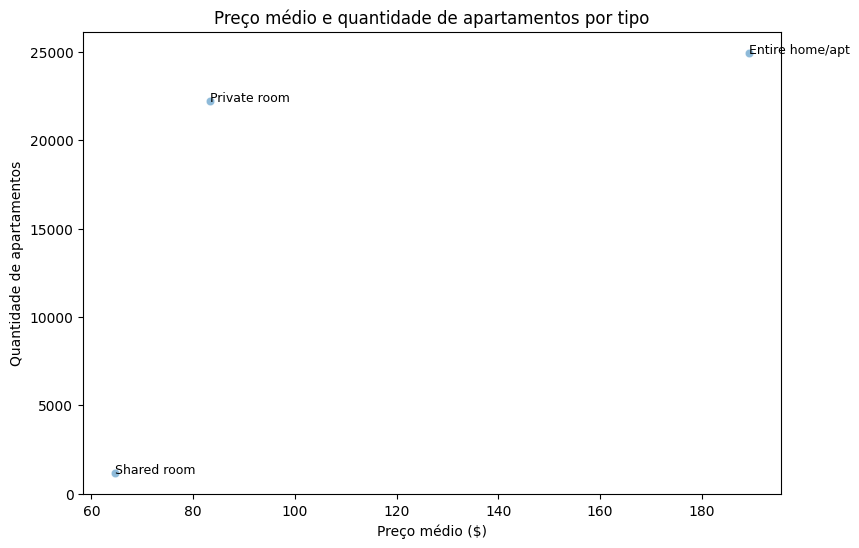

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

agrupamento_tipo = apartamentos.groupby("room_type").agg(
    quantidade=("id", "count"),
    preco_medio=("price", "mean")
).reset_index()

plt.figure(figsize=(9, 6))
sns.scatterplot(data=agrupamento_tipo, x="preco_medio", y="quantidade", alpha=0.5)
for i, row in agrupamento_tipo.iterrows():
    plt.text(
        row["preco_medio"],
        row["quantidade"],
        row["room_type"],
        fontsize=9
    )

plt.title("Preço médio e quantidade de apartamentos por tipo")
plt.xlabel("Preço médio ($)")
plt.ylabel("Quantidade de apartamentos")
plt.show()

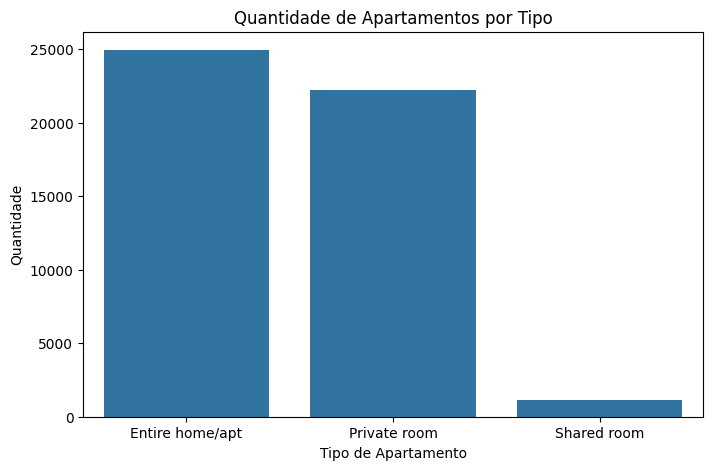

In [97]:
tipos_apt = apartamentos["room_type"].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=tipos_apt.index, y=tipos_apt.values)
plt.title("Quantidade de Apartamentos por Tipo")
plt.xlabel("Tipo de Apartamento")
plt.ylabel("Quantidade")
plt.show()

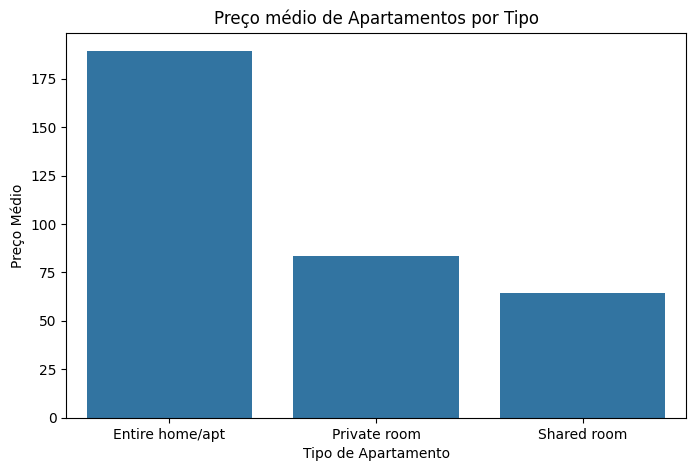

In [98]:
plt.figure(figsize=(8, 5))
sns.barplot(x=tipos_apt.index, y=apartamentos.groupby("room_type")["price"].mean())
plt.title("Preço médio de Apartamentos por Tipo")
plt.xlabel("Tipo de Apartamento")
plt.ylabel("Preço Médio")
plt.show()

### 3.4. Localização

#### 3.4.1. Bairro

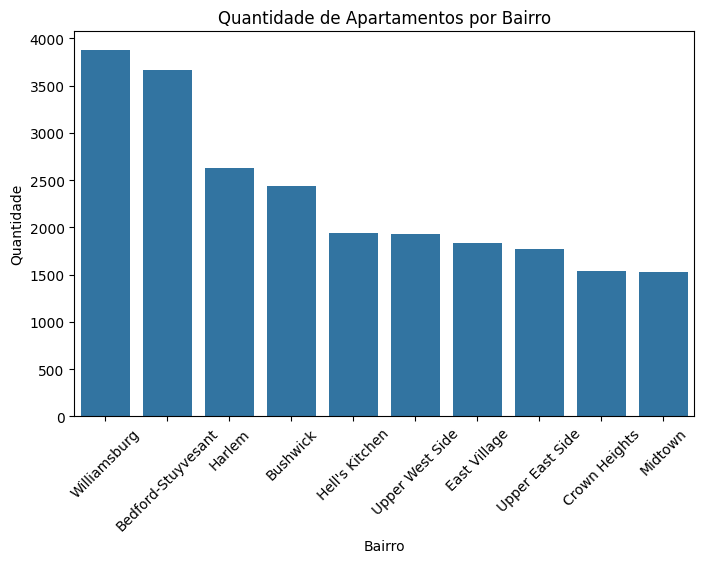

In [99]:
top_bairros_por_qtd = apartamentos["bairro"] \
    .value_counts() \
    .sort_values(ascending=False) \
    .head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_bairros_por_qtd.index, y=top_bairros_por_qtd.values)
plt.title("Quantidade de Apartamentos por Bairro")
plt.xlabel("Bairro")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.show()

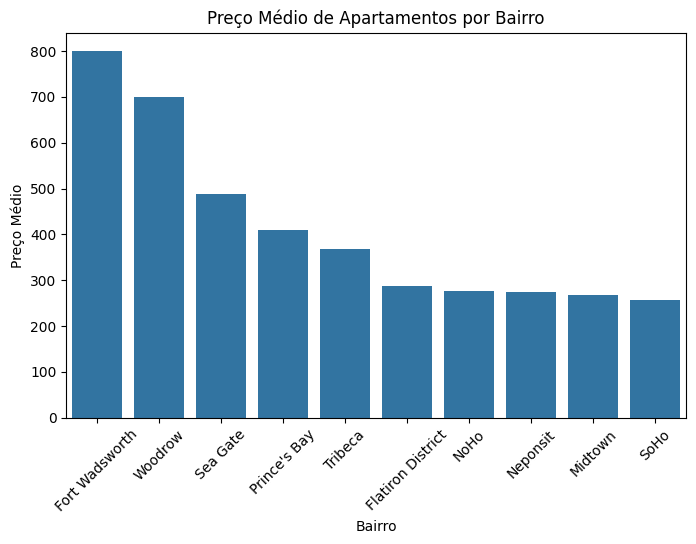

In [100]:
top_bairros_por_preco = apartamentos \
    .groupby("bairro")["price"].mean() \
    .sort_values(ascending=False) \
    .reset_index() \
    .head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x="bairro", y="price", data=top_bairros_por_preco)
plt.title("Preço Médio de Apartamentos por Bairro")
plt.xlabel("Bairro")
plt.ylabel("Preço Médio")
plt.xticks(rotation=45)
plt.show()

#### 3.4.2. Região (Grupo de Bairros)

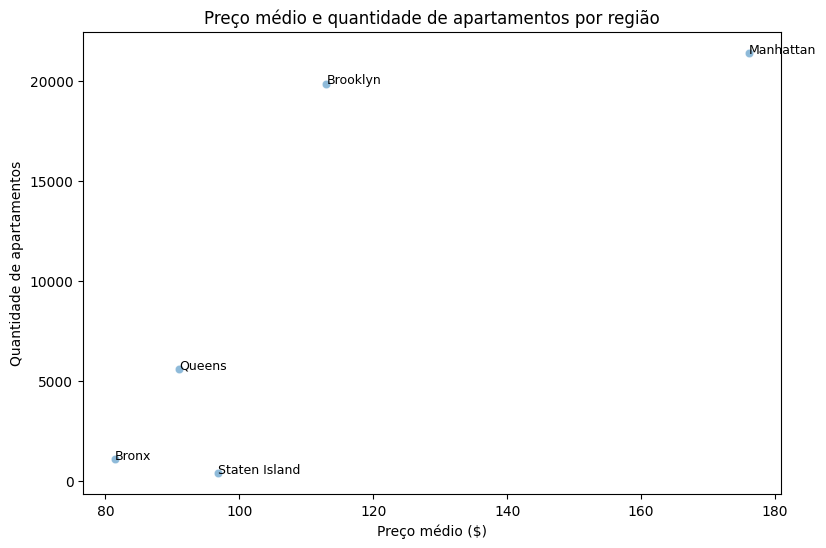

In [101]:
agrupamento_regiao = apartamentos.groupby("bairro_group").agg(
    quantidade=("id", "count"),
    preco_medio=("price", "mean")
).reset_index()

plt.figure(figsize=(9, 6))
sns.scatterplot(data=agrupamento_regiao, x="preco_medio", y="quantidade", alpha=0.5)
for i, row in agrupamento_regiao.iterrows():
    plt.text(
        row["preco_medio"],
        row["quantidade"],
        row["bairro_group"],
        fontsize=9
    )

plt.title("Preço médio e quantidade de apartamentos por região")
plt.xlabel("Preço médio ($)")
plt.ylabel("Quantidade de apartamentos")
plt.show()

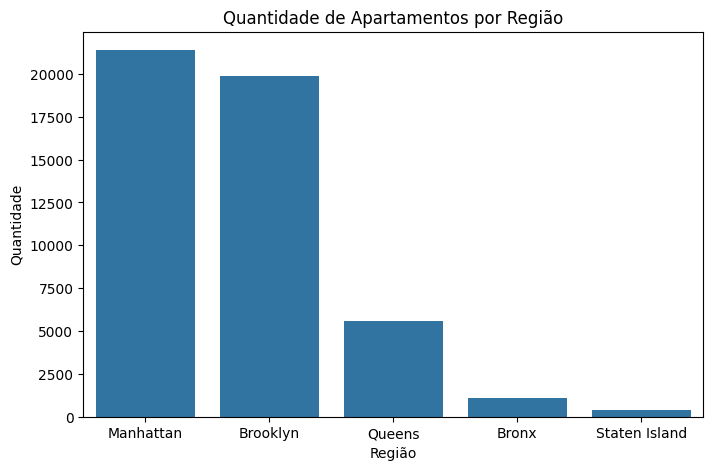

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

regioes = apartamentos["bairro_group"].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=regioes.index, y=regioes.values)
plt.title("Quantidade de Apartamentos por Região")
plt.xlabel("Região")
plt.ylabel("Quantidade")
plt.show()

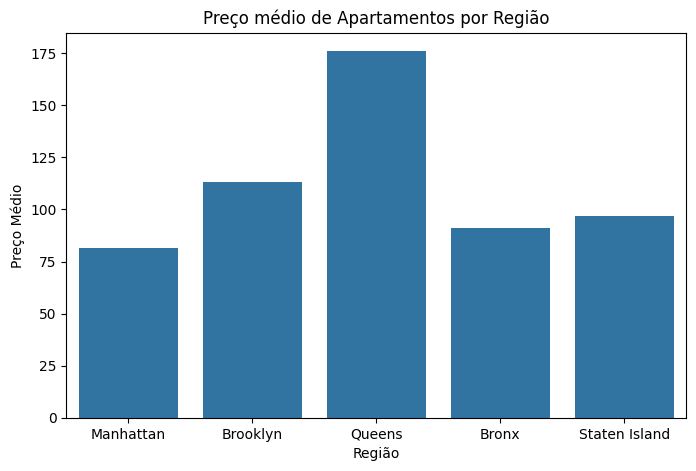

In [103]:
plt.figure(figsize=(8, 5))
sns.barplot(x=regioes.index, y=apartamentos.groupby("bairro_group")["price"].mean())
plt.title("Preço médio de Apartamentos por Região")
plt.xlabel("Região")
plt.ylabel("Preço Médio")
plt.show()

## 4. Respondendo as perguntas

### 4.1. Onde seria mais indicada a compra?

### 4.2. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Como podemos observar no tópico 3.2, a correlação do preço com o número mínimo de noites ou a disponibilidade ao longo do ano é baixa.

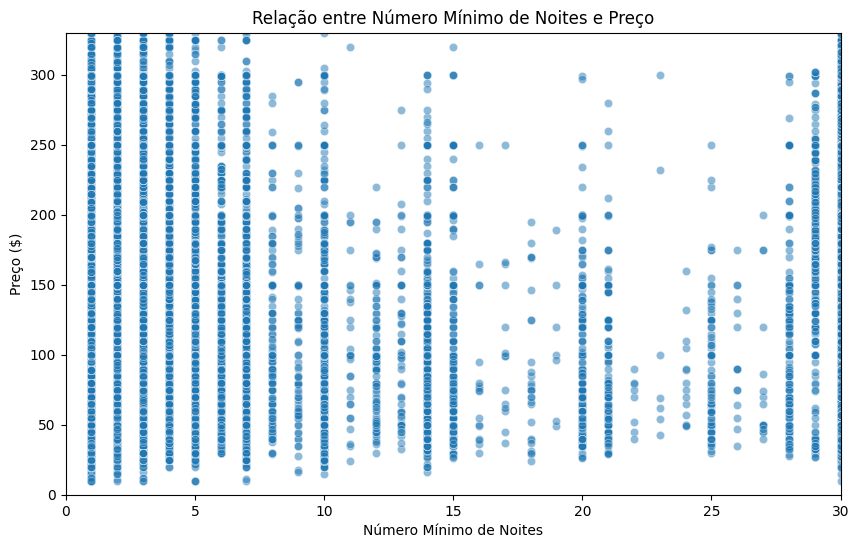

In [104]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=apartamentos, x="minimo_noites", y="price", alpha=0.5)

plt.title("Relação entre Número Mínimo de Noites e Preço")
plt.xlabel("Número Mínimo de Noites")
plt.ylabel("Preço ($)")
plt.ylim(0, apartamentos["price"].quantile(0.95))
plt.xlim(0, apartamentos["minimo_noites"].quantile(0.95))
plt.show()

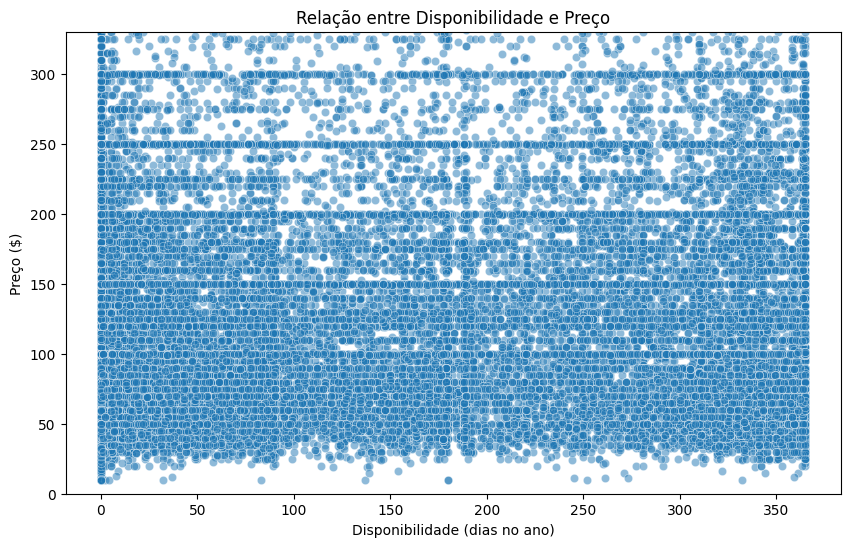

In [105]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=apartamentos, x="disponibilidade_365", y="price", alpha=0.5)

plt.title("Relação entre Disponibilidade e Preço")
plt.xlabel("Disponibilidade (dias no ano)")
plt.ylabel("Preço ($)")
plt.ylim(0, apartamentos["price"].quantile(0.95))
plt.show()

Conclusão: tanto pelos números quanto no gráfico é possível identificar que esses fatores influenciam muito pouco no preço

### 4.3. Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Para obter essa resposta, em primeiro lugar será analisado quais são as palavras ou conjuntos de palavras mais relacionados com as diferenças de preço:

In [116]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

vectorizer = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1,3))
modelo = LinearRegression()

x = vectorizer.fit_transform(apartamentos["nome"])
y = apartamentos["price"]
modelo.fit(x, y)

peso_ngramas = pd.DataFrame({
    'palavra': vectorizer.get_feature_names_out(),
    'peso': modelo.coef_
})
peso_ngramas.sort_values(by='peso', ascending=False).head(10)

,palavra,peso
22549,nyc renovated,1470.057491
14504,foot apt manhattan,1155.310602
6305,bedroom loft blocks,984.335196
1508,45 great location,922.356566
25884,rm historic,909.030376
19415,lovely midtown,868.178638
232,1500,864.931630
12436,deluxe 2br,843.631095
15790,gym walk,834.286224
541,1br gym walk,834.286224


Também será analisado quais são as palavras mais recorrentes entre os apartamentos mais caros.

Para isso, serão selecionados os apartamentos cujo preço é ao menos duas vezes maior que a média do bairro, incluindo os outliers ignorados nas análises anteriores.

In [117]:
apartamentos_caros = outliers_bairro[outliers_bairro['proporcao'] > 2]
vectorizer = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1,3))
modelo = LinearRegression()

x = vectorizer.fit_transform(apartamentos_caros["nome"])
y = apartamentos_caros["price"]
modelo.fit(x, y)

peso_ngramas = pd.DataFrame({
    'palavra': vectorizer.get_feature_names_out(),
    'peso': modelo.coef_,
    'recorrencia': x.toarray().sum(axis=0)
})

Palavras / N-gramas mais frequentes entre os apartamentos mais caros:

In [111]:
peso_ngramas.sort_values(by='recorrencia', ascending=False).head(10)

,palavra,peso,recorrencia
366,bedroom,-77.599551,270
1210,luxury,-146.475108,197
1158,loft,-95.091846,194
205,apartment,-348.219460,175
227,apt,629.517745,157
528,brooklyn,-270.471183,152
1268,manhattan,51.025126,142
1455,park,-92.698147,136
1531,private,-243.391489,127
714,duplex,-290.048739,124


Neste caso, temos muitas palavras comuns, o que não traz muitas respostas, com exceção da palavra "luxury", que indica que estes imóveis tendem a ser luxuosos.

Palavras / N-gramas que mais aumentam o preço:

In [112]:
peso_ngramas.sort_values(by='peso', ascending=False).head(10)

,palavra,peso,recorrencia
614,city apartment,13181.826559,3
1281,manhattan views,11843.504113,3
701,doorman gym,11226.409261,13
852,film location,10896.100647,2
1878,time sqr,9780.685755,2
877,free wifi,9765.016403,3
1140,lit,9633.722509,2
1539,private deck,9141.405903,4
1981,village 2br,9107.821510,3
81,2br heart,8961.323354,2
